In [1]:
import tensorflow as tf
import tensorflow.contrib.slim as slim
import tensorflow.contrib.slim.nets as nets
from urllib.request import urlretrieve
import tarfile
import os

tf.logging.set_verbosity(tf.logging.ERROR)
sess = tf.InteractiveSession()

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
image = tf.Variable(tf.zeros((224, 224, 3)))
def vgg(image):
    mean = [103.939, 116.779, 123.68]
    r,g,b=tf.split(image,3,2)
    r=tf.subtract (r,123.68)
    g=tf.subtract (g, mean[1])
    b=tf.subtract (b, mean[0])
    image=tf.concat([b,g,r],2)
    
    preprocessed = tf.expand_dims(image, 0)
    arg_scope = nets.vgg.vgg_arg_scope(weight_decay=0.0)
    with slim.arg_scope(arg_scope):
        logits, _ = nets.vgg.vgg_16(
            preprocessed, 1000, is_training=False)
        #logits = logits[:,1:] # ignore background class
        probs = tf.nn.softmax(logits) # probabilities
    return logits, probs
def inception(image, reuse=False):
    preprocessed = tf.multiply(tf.subtract(tf.expand_dims(image, 0), 0.5), 2.0)
    with slim.arg_scope(nets.inception.inception_v3_arg_scope(weight_decay=0.0)):
        logits, end_points = nets.inception.inception_v3(preprocessed, num_classes=1001,is_training=False)
        logits = logits[:,1:]
        probs = tf.nn.softmax(logits) # probabilities
    return logits, probs
def vgg19(image):
    preprocessed = tf.multiply(tf.subtract(tf.expand_dims(image, 0), 0.5), 2.0)
    arg_scope = nets.vgg.vgg_arg_scope(weight_decay=0.0)
    with slim.arg_scope(arg_scope):
        logits, _ = nets.vgg.vgg_19(
            preprocessed, 1000, is_training=False)
       # logits = logits[:,1:] # ignore background class
        probs = tf.nn.softmax(logits) # probabilities
    return logits, probs

def get_vars(model_name='vgg_16/'):#'InceptionV3/'
    restore_vars = [
        var for var in tf.global_variables()
        if var.name.startswith(model_name)
    ]
    return restore_vars


In [3]:
'''logits, probs = inception(image)
get_vars(model_name='InceptionV3/')'''

"logits, probs = inception(image)\nget_vars(model_name='InceptionV3/')"

In [4]:
logits, probs = vgg(image)

In [5]:
tf.global_variables()

[<tf.Variable 'Variable:0' shape=(224, 224, 3) dtype=float32_ref>,
 <tf.Variable 'vgg_16/conv1/conv1_1/weights:0' shape=(3, 3, 3, 64) dtype=float32_ref>,
 <tf.Variable 'vgg_16/conv1/conv1_1/biases:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'vgg_16/conv1/conv1_2/weights:0' shape=(3, 3, 64, 64) dtype=float32_ref>,
 <tf.Variable 'vgg_16/conv1/conv1_2/biases:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'vgg_16/conv2/conv2_1/weights:0' shape=(3, 3, 64, 128) dtype=float32_ref>,
 <tf.Variable 'vgg_16/conv2/conv2_1/biases:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'vgg_16/conv2/conv2_2/weights:0' shape=(3, 3, 128, 128) dtype=float32_ref>,
 <tf.Variable 'vgg_16/conv2/conv2_2/biases:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'vgg_16/conv3/conv3_1/weights:0' shape=(3, 3, 128, 256) dtype=float32_ref>,
 <tf.Variable 'vgg_16/conv3/conv3_1/biases:0' shape=(256,) dtype=float32_ref>,
 <tf.Variable 'vgg_16/conv3/conv3_2/weights:0' shape=(3, 3, 256, 256) dtype=float32_ref>,
 <tf.V

In [6]:
'''logits, probs = inception(image)
saver = tf.train.Saver(get_vars(model_name='InceptionV3/'))
saver.restore(sess,'models/inception_v3.ckpt')'''

"logits, probs = inception(image)\nsaver = tf.train.Saver(get_vars(model_name='InceptionV3/'))\nsaver.restore(sess,'models/inception_v3.ckpt')"

In [7]:
import numpy as np
weights = np.load('models/vgg16.npy',encoding="latin1").item()

print(weights.keys())
    
#print loss_l2
load_weights = {}
load_weights['vgg_16/conv1/conv1_1'] = weights['conv1_1']
load_weights['vgg_16/conv1/conv1_2'] = weights['conv1_2']
load_weights['vgg_16/conv2/conv2_1'] = weights['conv2_1']
load_weights['vgg_16/conv2/conv2_2'] = weights['conv2_2']
load_weights['vgg_16/conv3/conv3_1'] = weights['conv3_1']
load_weights['vgg_16/conv3/conv3_2'] = weights['conv3_2']
load_weights['vgg_16/conv3/conv3_3'] = weights['conv3_3']
load_weights['vgg_16/conv4/conv4_1'] = weights['conv4_1']
load_weights['vgg_16/conv4/conv4_2'] = weights['conv4_2']
load_weights['vgg_16/conv4/conv4_3'] = weights['conv4_3']
load_weights['vgg_16/conv5/conv5_1'] = weights['conv5_1']
load_weights['vgg_16/conv5/conv5_2'] = weights['conv5_2']
load_weights['vgg_16/conv5/conv5_3'] = weights['conv5_3']
print(np.array(weights['fc6'][0]).shape)   
for key in load_weights:
    with tf.variable_scope(key, reuse=True):
        for subkey, data in zip(('weights', 'biases'), load_weights[key]):
            sess.run(tf.get_variable(subkey).assign(data))

with tf.variable_scope('vgg_16/fc6', reuse=True):
    sess.run(tf.get_variable("weights").assign(np.array(weights["fc6"][0].reshape(7,7,512,4096))))
    sess.run(tf.get_variable("biases").assign(weights['fc6'][1]))
    
with tf.variable_scope('vgg_16/fc7', reuse=True):
    sess.run(tf.get_variable("weights").assign(np.array(weights["fc7"][0].reshape(1,1,4096,4096))))
    sess.run(tf.get_variable("biases").assign(weights['fc7'][1]))

    
with tf.variable_scope('vgg_16/fc8', reuse=True):
    sess.run(tf.get_variable("weights").assign(np.array(weights["fc8"][0]).reshape(1,1,4096,1000)))
    sess.run(tf.get_variable("biases").assign(weights['fc8'][1]))

dict_keys(['conv5_1', 'conv1_2', 'conv4_3', 'conv3_2', 'fc7', 'conv5_3', 'conv2_2', 'conv4_2', 'conv3_3', 'fc8', 'conv1_1', 'conv3_1', 'conv2_1', 'conv5_2', 'fc6', 'conv4_1'])
(25088, 4096)


In [8]:
'''logits, probs = vgg19(image)
saver = tf.train.Saver(get_vars(model_name='vgg_19/'))
saver.restore(sess,'models/vgg_19.ckpt')'''

"logits, probs = vgg19(image)\nsaver = tf.train.Saver(get_vars(model_name='vgg_19/'))\nsaver.restore(sess,'models/vgg_19.ckpt')"

In [9]:
import json
import matplotlib.pyplot as plt
import urllib

def classify(img, target_class=None):
    p = sess.run(probs, feed_dict={image: img})[0]
    topk = list(p.argsort()[-10:][::-1])
    print(topk)
    topprobs = p[topk]
    barlist = plt.bar(range(10), topprobs)
    if target_class in topk:
        barlist[topk.index(target_class)].set_color('r')
    plt.ylim([0, 1.1])
    plt.xticks(range(10),
               topk,
               rotation='vertical')

    plt.show()
import math   
def classifys(imgs,target_class):

    plt.figure(1,figsize=(30,30))
    num=len(imgs)+1
    n_rows=math.ceil(num/4)+1
    
    for i in range(len(imgs)):
        p = sess.run(probs, feed_dict={image: imgs[i]})[0]
        topk = list(p.argsort()[-10:][::-1])
        topprobs = p[topk]
        plt.subplot(n_rows,2,i+1)
        barlist = plt.bar(range(10), topprobs)
        if target_class in topk:
            barlist[topk.index(target_class)].set_color('r')
        plt.ylim([0, 1.1])
        plt.xticks(range(10),
                    topk,
                    rotation='vertical')

    plt.show()
    
    

In [10]:
import PIL
import numpy as np
import os
from skimage.io import imread
from skimage.transform import resize
def getImage(img_path,image_size=299):
    img = PIL.Image.open(img_path)
    big_dim = max(img.width, img.height)
    wide = img.width > img.height
    new_w = image_size if not wide else int(img.width * image_size / img.height)
    new_h = image_size if wide else int(img.height * image_size / img.width)
    img = img.resize((new_w, new_h)).crop((0, 0, image_size, image_size))
    img = (np.asarray(img) / 255.0).astype(np.float32)
    #classify(img, correct_class=img_class)
    return img

def getImages(imgs_path,image_size=224):
    images=[]
    path=os.listdir(imgs_path)
    for i in path:
        img_path=os.path.join(imgs_path,i)
        images.append(getImage(img_path,image_size=image_size))
    return images
    

In [11]:
def adsample(lr=0.1,steps=50,target=924,img=None,image_size=224):
    x = tf.placeholder(tf.float32, (image_size, image_size, 3))

    x_hat = image # our trainable adversarial input
    #rint(x)
   #print(img)
    assign_op = tf.assign(x_hat, x)
    learning_rate = tf.placeholder(tf.float32, ())
    y_hat = tf.placeholder(tf.int32, ())

    labels = tf.one_hot(y_hat, 1000)
    loss = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=[labels])
    optim_step = tf.train.GradientDescentOptimizer(
        learning_rate).minimize(loss, var_list=[x_hat])
    epsilon = tf.placeholder(tf.float32, ())

    below = x - epsilon
    above = x + epsilon
    projected = tf.clip_by_value(tf.clip_by_value(x_hat, below, above), 0, 1)
    with tf.control_dependencies([projected]):
        project_step = tf.assign(x_hat, projected)

    demo_epsilon = 2.0/255.0 # a really small perturbation
    demo_lr = lr
    demo_steps = steps
    demo_target=target # "guacamole"

    # initialization step
    sess.run(assign_op, feed_dict={x: img})

    # projected gradient descent
    for i in range(demo_steps):
        # gradient descent step
        _, loss_value = sess.run(
            [optim_step, loss],
            feed_dict={learning_rate: demo_lr, y_hat: demo_target})
        # project step
        sess.run(project_step, feed_dict={x: img, epsilon: demo_epsilon})
        if (i+1) % 10 == 0:
            print('step %d, loss=%g' % (i+1, loss_value))

    return x_hat.eval() # retrieve the adversarial example


def adSamples(imgs,lr=0.1,steps=50,target=924,image_size=224):
    adimgs=[]
    for i in imgs:
        adimgs.append(adsample(lr,steps,target,img=i,image_size=image_size))
    return adimgs

In [18]:
imgs=getImages("cats",image_size=224)[:15]

[644, 111, 626, 530, 818, 470, 607, 619, 845, 826]


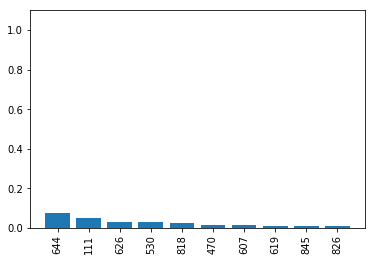

In [19]:
classify(imgs[1])

In [14]:

advs=adSamples(lr=0.1,imgs_path="dogs",steps=1,image_size=224)

TypeError: adSamples() got an unexpected keyword argument 'imgs_path'

ValueError: num must be 1 <= num <= 10, not 11

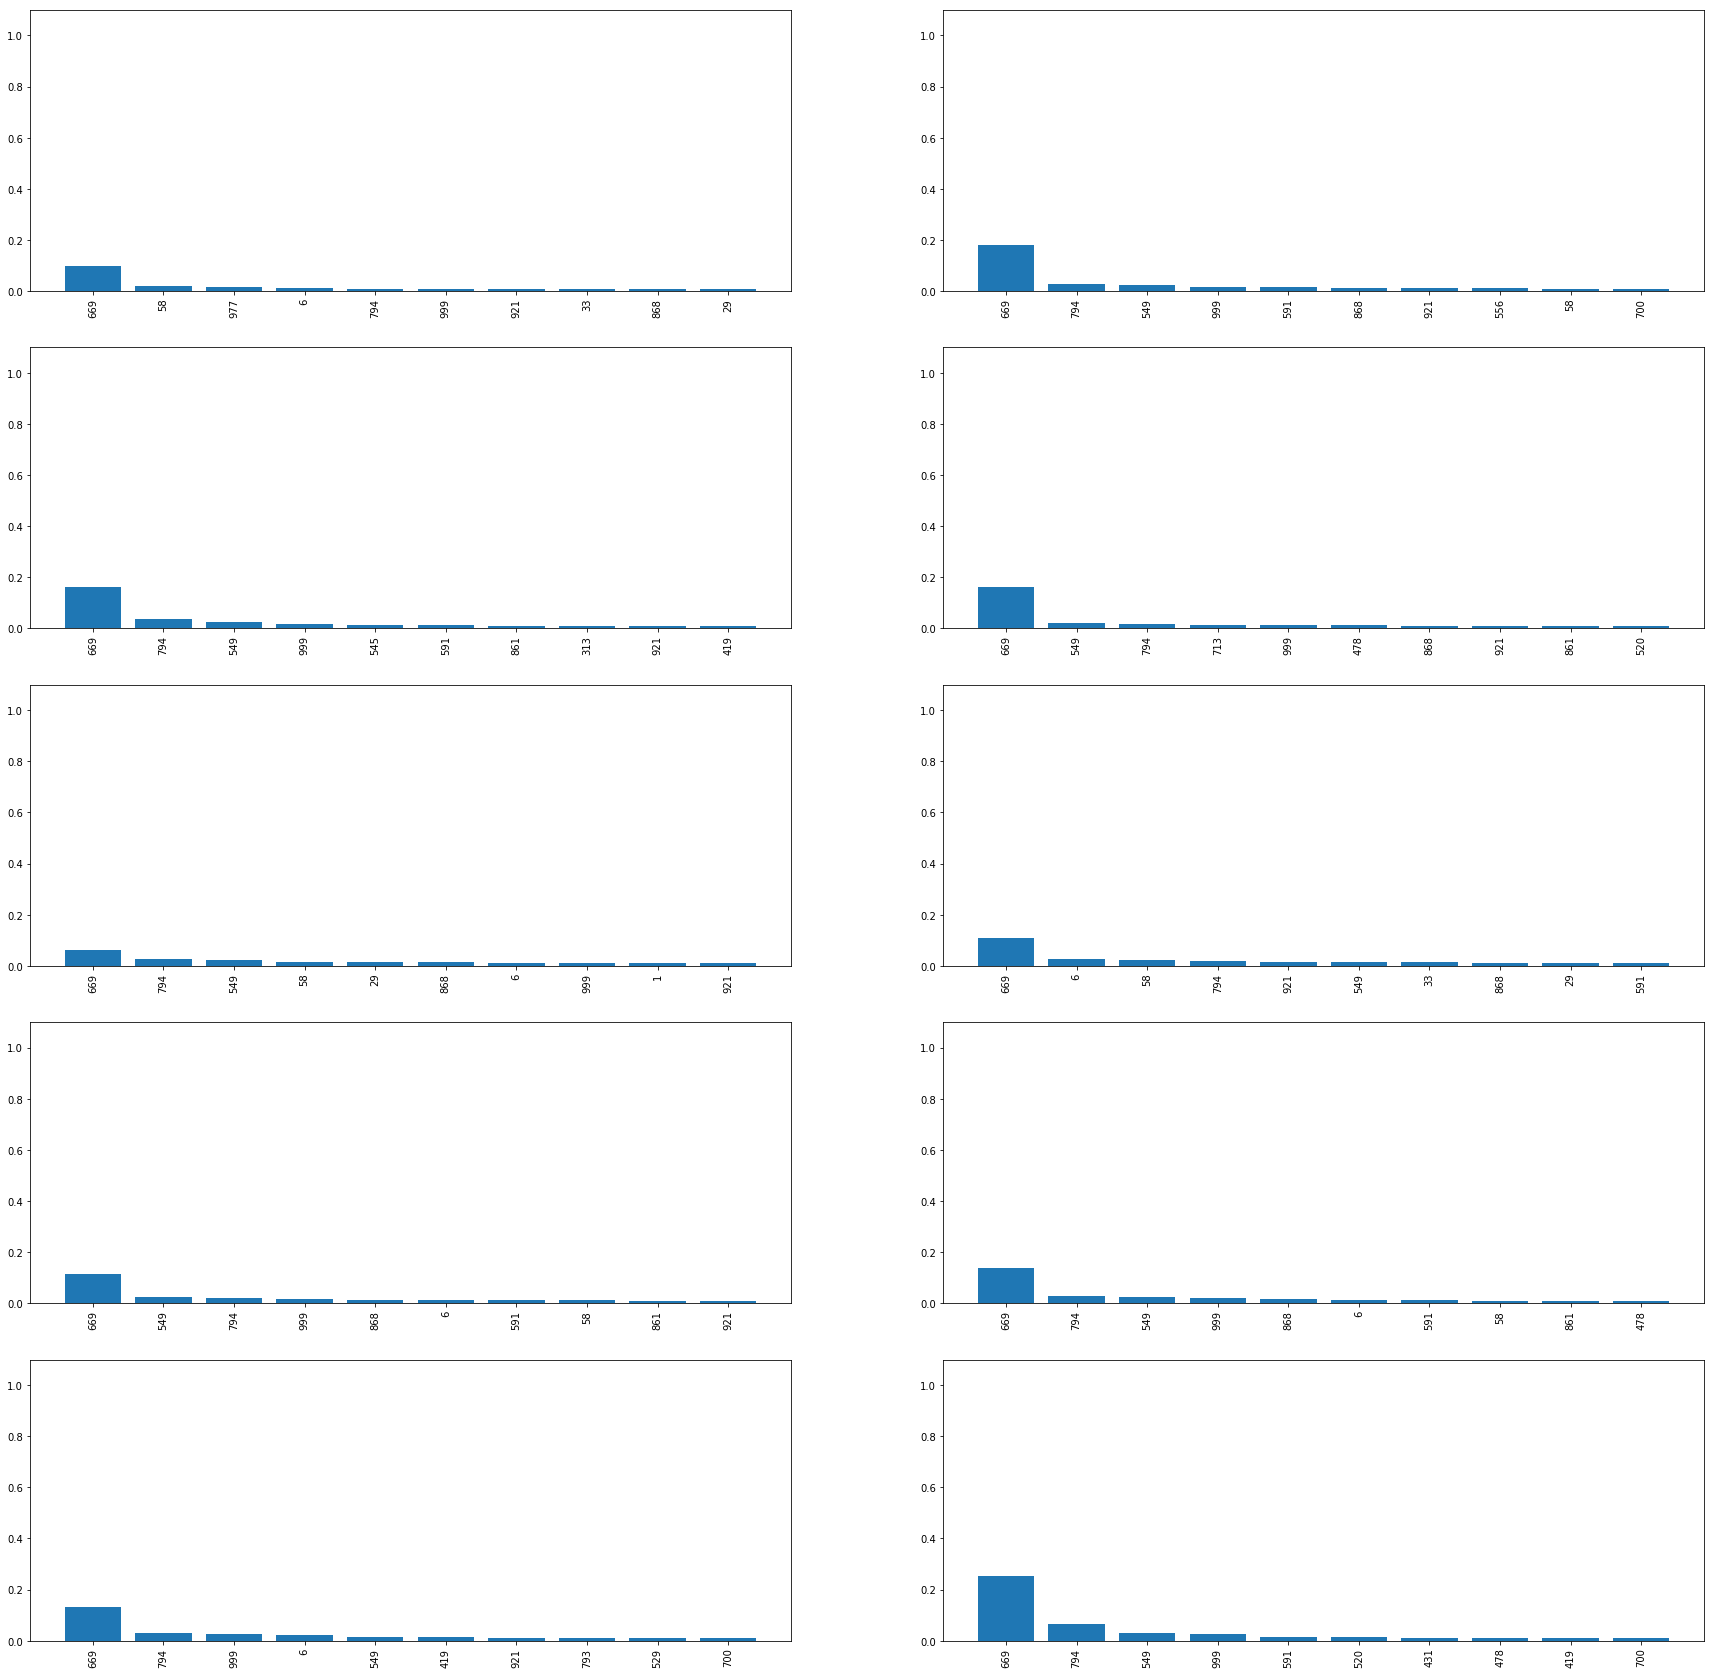

In [14]:
classifys(advs, target_class=924)